# Identity
Name: Michelle Nathania\
Student ID: 2702208575\
Code A

# 2. CNN for Brain Tumor Classification

Before we begin, let's import all the libraries needed for this project. I will mainly use Tensorflow libraries for building the neural models.

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import zipfile
import os
import shutil

import numpy as np
import pandas as pd
import random as rd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import cv2
from glob import glob

In [ ]:
# Set seed for a more reproducible result
# So every time it runs the result won't differ much
SEED_VALUE=123
rd.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

## a. EDA and Data Preprocessing

### Data importing
These are the processes to import the dataset. I have uploaded the zip file to Google Drive under the name 'brain_tumor.zip'. Then I imported the file from Google Drive, extract it to Colab's content folder, and it has been imported successfully, as we can see that the directory has listed 'testing' and 'training' for the unzipped data.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/brain_tumor.zip'
extract_to = '/content/brain_tumor'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
os.listdir('/content/brain_tumor')

['Testing', 'Training']

### Image count
Here, we can see the amount of images in each class for both train & test dataset. There are 4 classes: no tumor, glioma, meningioma, and pituitary.

In [ ]:
def count_images(path):
    counts = {}
    for folder in os.listdir(path):
        class_path = os.path.join(path, folder)
        if os.path.isdir(class_path):
            counts[folder] = len(os.listdir(class_path))
    return counts

train_counts = count_images('/content/brain_tumor/Training')
test_counts = count_images('/content/brain_tumor/Testing')

print("Training data:")
for k, v in train_counts.items():
    print(f"- {v} images are {k}")

print("\nTesting data:")
for k, v in test_counts.items():
    print(f"- {v} images are {k}")

Training data:
- 1339 images are meningioma
- 1321 images are glioma
- 1595 images are notumor
- 1457 images are pituitary

Testing data:
- 306 images are meningioma
- 300 images are glioma
- 405 images are notumor
- 300 images are pituitary


In [ ]:
image_paths = glob(extract_to + '/**/*.jpg', recursive=True)

### Check the sample of each class

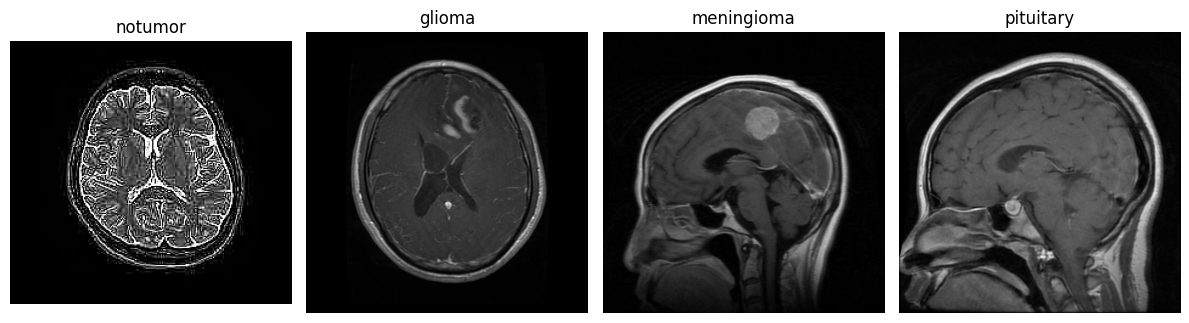

In [ ]:
categories = ['notumor', 'glioma', 'meningioma', 'pituitary']
base_path = '/content/brain_tumor/Training'
plt.figure(figsize=(12, 6))

for i, category in enumerate(categories):
    img_path = os.path.join(base_path, category)
    img_file = os.listdir(img_path)[0]  # just pick the first image in the folder
    img = mpimg.imread(os.path.join(img_path, img_file))

    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')  # grayscale display
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

I have visualized the sample from each class in training data to see how is the dataset. There are 4 classes, so there are 4 outputs as well. The image seems to be MRI scan from brain, so it is in greyscale. The images seem to be about the same size, but from human's eyesight, it seems like the pictures may have different contrast and brightness -- so it is good to check the stats to confirm the assumption.

### Check image shape

In [ ]:
unique_shapes = set()
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        shape = img.shape
        # For RGB images
        if len(shape) == 3:
            h, w, c = shape
        # Assuming one channel only (RGB) because the image is in grayscale
        elif len(shape) == 2:
            h, w = shape
            c = 1
        unique_shapes.add((h, w, c))

print("Unique image dimensions (Height, Width, Channel):")
for dims in unique_shapes:
    print(dims)

Unique image dimensions (Height, Width, Channel):
(395, 367, 3)
(290, 236, 3)
(717, 717, 3)
(302, 216, 3)
(245, 206, 3)
(512, 434, 3)
(250, 201, 3)
(274, 230, 3)
(442, 442, 3)
(228, 233, 3)
(480, 853, 3)
(484, 405, 3)
(248, 208, 3)
(417, 428, 3)
(344, 320, 3)
(273, 236, 3)
(236, 236, 3)
(244, 206, 3)
(470, 469, 3)
(214, 229, 3)
(496, 453, 3)
(216, 234, 3)
(439, 645, 3)
(395, 416, 3)
(236, 255, 3)
(342, 323, 3)
(257, 235, 3)
(1080, 1920, 3)
(340, 507, 3)
(222, 233, 3)
(260, 314, 3)
(486, 421, 3)
(512, 416, 3)
(270, 250, 3)
(415, 339, 3)
(301, 275, 3)
(243, 207, 3)
(903, 721, 3)
(300, 227, 3)
(372, 341, 3)
(592, 562, 3)
(282, 230, 3)
(225, 209, 3)
(306, 278, 3)
(361, 642, 3)
(355, 330, 3)
(228, 236, 3)
(872, 850, 3)
(213, 210, 3)
(223, 224, 3)
(248, 200, 3)
(218, 234, 3)
(320, 497, 3)
(320, 257, 3)
(248, 257, 3)
(365, 306, 3)
(613, 605, 3)
(239, 236, 3)
(354, 298, 3)
(258, 300, 3)
(280, 236, 3)
(201, 173, 3)
(228, 228, 3)
(480, 480, 3)
(198, 150, 3)
(244, 201, 3)
(234, 215, 3)
(286, 224,

It seems like the images are in different shapes! But we can be sure about one thing: the color channels number is 3, which means it is in RGB, despite the grayscale look. We need to preprocess the data so they are all in the same shapes, preferably (224, 224, 3), the standard shape in CNN, especially since we are using AlexNet that receives (224, 224, 3) as the input shape.

### Plotting the pixel intensity

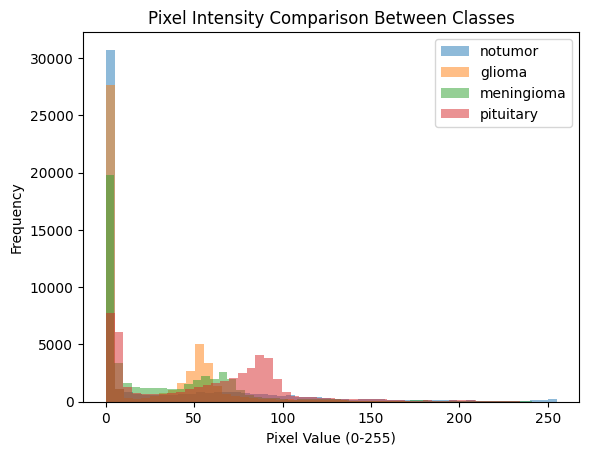

In [ ]:
for cls in categories:
    cls_path = f'/content/brain_tumor/Training/{cls}'
    img_file = os.listdir(cls_path)[0]  # Take one image from each class
    img = cv2.imread(os.path.join(cls_path, img_file))
    img = cv2.resize(img, (224, 224))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pixels = gray.flatten()

    plt.hist(pixels, bins=50, alpha=0.5, label=cls)

plt.title("Pixel Intensity Comparison Between Classes")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
mean = np.mean(gray)
std_dev = np.std(gray)
print("Brightness: ", mean)
print("Contrast: ", std_dev)

Brightness:  58.68365353954081
Contrast:  46.39978280553017


Plotting the pixel intensity is done to check how the pixel values are distributed, so we may as well understand the brightness and contrast of our data.

---

The result tells us that there is a really tall peak on the left side -- meaning that the image is dark. This confirms our observation, that the data is mostly in black and white because it is an MRI scan result. The dominant black result might make the model overfit, so data augmentation could help. There is a small peak near 50 to 150 pixel, perhaps due to the skull structure or other organs detected. The histograms are similar, but not identical across classes. We can see that the no tumor brain scans has the highest 0 pixel value compared to the others, but for the other classes, the values are somewhat similar. The brightness is 58.68, indicating the images are relatively dark. The contrast is 46.39, indicating the images have moderate contrast.

### Data preprocessing
- Split the data train and val with val = 0.15 train.
- Reshape data to (224, 224, 3) and normalize the pixel values to [0, 1] so inputs are small and more similar, helps the model to converge better.
- Perform data augmentation (rotating, moving, zooming, etc) especially since the images are similar across classes and the dataset is limited.

### Splitting train & val

In [ ]:
# File directory
train_dir = '/content/brain_tumor/Training'
val_dir = '/content/brain_tumor/Validation'

if not os.path.exists(val_dir):
    os.makedirs(val_dir)

for cls in categories:
    class_train_dir = os.path.join(train_dir, cls)
    class_val_dir = os.path.join(val_dir, cls)

    if not os.path.exists(class_val_dir):
        os.makedirs(class_val_dir)

    # List all images in the class directory
    images = os.listdir(class_train_dir)

    # Shuffle the images randomly and take the first 15% for validation
    rd.shuffle(images)
    val_images = images[:int(0.15 * len(images))]  # 15% for validation

    # Move those images to the validation directory
    for img in val_images:
        shutil.move(os.path.join(class_train_dir, img), os.path.join(class_val_dir, img))

print("Data split into training and validation.")

Data split into training and validation.


In [ ]:
# Train data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

# Val data generator
val_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    '/content/brain_tumor/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Val generator
val_generator = val_datagen.flow_from_directory(
    '/content/brain_tumor/Validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.


This is done to split our train data to train and val (85/15). We will train the model using train data, validate it with val data, and predict the output with test data (which is already splitted from the beginning). The cell above has done the data augmentation and normalization as well.
- Rescaling the pixel value by dividing by 255 so the value is more uniform around 0 to 1.
- Shear the image by 0.2, zoom by 0.2, rotate by 40, shift by 0.2 (width and height), fill the missing pixels after transformations using the 'nearest' mode. Data augmentation is done to make the model generalize better, especially since we know that the data is similar across classes.
- Augmentation is not applied on val datagen because we want the val data to resemble the real data as much as possible.

## b. AlexNet Baseline Model
AlexNet is a well-known CNN architecture, developed by Alex Krizhevsky in 2012.
- Receives 224x224x3 input shape (224x224 image with RGB scale).
- Uses 5 convolutional layers in total. These layers are to extract features from the images.
- Uses max pooling layers that reduce the spatial dimensions of the feature maps, keeping only the most important information.
- After the convolutional layers, the layers are flattened and passed to fully-connected or dense layers. AlexNet uses 3 dense layers in total.
- Use softmax activation for the output layer to predict the probability of an image belonging to a class in multiclass classification.

In [ ]:
def alexnet(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Convolutional Layer 4
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Convolutional Layer 5
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    # Flatten and Fully Connected Layer 1
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))

    # Fully Connected Layer 2
    model.add(Dense(4096, activation='relu'))

    # Fully Connected Layer 3 (Output Layer)
    model.add(Dense(num_classes, activation='softmax'))  # For multiclass classification

    return model


In [ ]:
model = alexnet(input_shape=(224, 224, 3), num_classes=4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(train_generator, epochs=15, validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 89s 520ms/step - accuracy: 0.3331 - loss: 1.6293 - val_accuracy: 0.6749 - val_loss: 0.8479
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 472ms/step - accuracy: 0.5937 - loss: 0.9915 - val_accuracy: 0.7462 - val_loss: 0.7152
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 71s 469ms/step - accuracy: 0.6630 - loss: 0.8426 - val_accuracy: 0.7567 - val_loss: 0.6335
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 74s 488ms/step - accuracy: 0.7163 - loss: 0.7196 - val_accuracy: 0.7860 - val_loss: 0.5660
Epoch 5/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 473ms/step - accuracy: 0.7440 - loss: 0.6503 - val_accuracy: 0.7544 - val_loss: 0.5652
Epoch 6/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 70s 463ms/step - accuracy: 0.7557 - loss: 0.6373 - val_accuracy: 0.8140 - val_loss: 0.4672
Epoch 7/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 71s 467ms/step - accuracy: 0.7694 - loss: 0.6038 - val_accuracy: 0.7591 - val_loss: 0.5881
Epoch 8/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 466ms/step - accuracy: 0.7711 - loss: 0

The train accuracy started off low at 0.33 accuracy, but it constantly went up until it reaches 0.81 accuracy. This means that the model is learning something and not just memorizing the pattern. This statement is supported with the validation accuracy that is also high, which starts at 0.67 and ends at 0.82. There were slight fluctuations in the val accuracy, can be caused by overfitting or learning rate that is too high (the LR is using the default LR 1e-3).

## c. AlexNet Modification Model
For the modification, I want to stick with AlexNet so I can compare how the two AlexNet models differ before and after I add BatchNormalization and Dropout layers.
- **BatchNormalization will be added after the last convolutional layer** to help normalize the feature maps coming from the final convolution layer and help to smooth them out before it is flatten and passd to the dense layer. This is done with the hope of reducing overfitting.
- Add **dropout layers** after dense hidden layers and **test out which value is the best** (0.2 to 0.5 with the step of 0.1, because the dataset is limited).
- Try **tuning the number of neurons** on the dense layer. Even if the original AlexNet has 4096 neurons on the dense layers, but AlexNet is used to train a very large image dataset -- while here, we only have < 5000 data to train. So hopefully, by tuning the number of neurons to smaller choices, the model may perform better.
- Tune the **learning rate for Adam optimizer** (1e-3 to 1e-6) to see which learning rate is the best.

In [ ]:
def alexnet_model_builder(hp):
    model_tuned = Sequential()

    model_tuned.add(Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224, 224, 3)))
    model_tuned.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model_tuned.add(Conv2D(256, kernel_size=(5,5), padding='same', activation='relu'))
    model_tuned.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model_tuned.add(Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'))
    model_tuned.add(Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'))
    model_tuned.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model_tuned.add(BatchNormalization())
    model_tuned.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model_tuned.add(Flatten())

    # Tune dense layer units
    hp_units = hp.Int('units', min_value=256, max_value=1024, step=128)

    # Tune dropout rate
    hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    model_tuned.add(Dense(hp_units, activation='relu'))
    model_tuned.add(Dropout(hp_dropout))
    model_tuned.add(Dense(hp_units//2, activation='relu'))
    model_tuned.add(Dropout(hp_dropout))

    model_tuned.add(Dense(4, activation='softmax'))

    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5, 1e-6])

    model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model_tuned

In [ ]:
tuner = kt.Hyperband(alexnet_model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='ext',
                     project_name='alexnet_finetune')

tuner.search(train_generator,
             validation_data=val_generator,
             epochs=10)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 11m 53s]
val_accuracy: 0.8771929740905762

Best val_accuracy So Far: 0.8783625960350037
Total elapsed time: 02h 28m 44s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'units': 256,
 'dropout_rate': 0.2,
 'learning_rate': 0.0001,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0014'}

The result from the fine-tuning is the model will have its best accuracy at 0.87, with the structure:
- 5 Convolutional Layers (same as AlexNet)
- 1 Batch Normalization after the last convolution layer
- Use 3 FC/Dense Layers (same as AlexNet)
- Dense Layers will use 256 and 128 neurons, which is wayyy lower than AlexNet with 4096 neurons! 🫣 The dataset is small, that may explain why lower neurons are better -- the model is not as complex as the baseline model.
- Dropout layer after dense layer with the dropout rate = 0.2. Not too much to drop because the dataset is limited, so it is perfect to balance the small data but still prevent it from overfitting.
- Adjust learning rate from 0.001 to 0.0001 (1e-3 to 1e-4).

## d. Evaluation

In [ ]:
# Preparing data test
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/brain_tumor/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [ ]:
# Predict using baseline model
preds_baseline = model.predict(test_generator)

# Predict using tuned model
preds_tuned = best_model.predict(test_generator)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step


Since we are using softmax function for the output layer, it will be an array of arrays of the prediction of how likely the image belongs to a category. So, we want to extract the max value from the array, because that means that the image is the MOST likely to be classified to that class.

In [ ]:
preds_baseline

array([[2.6862928e-01, 6.1772776e-01, 2.0606432e-02, 9.3036503e-02],
       [5.5997026e-01, 1.0374496e-01, 1.2059796e-02, 3.2422492e-01],
       [9.8922825e-01, 8.9801410e-03, 1.2291399e-04, 1.6687528e-03],
       ...,
       [4.8605166e-02, 1.0835347e-02, 1.0133509e-02, 9.3042600e-01],
       [3.1239119e-01, 1.6697145e-01, 3.5033042e-03, 5.1713401e-01],
       [5.4361369e-02, 1.8473152e-02, 3.4244519e-03, 9.2374104e-01]],
      dtype=float32)

In [ ]:
y_pred_baseline = np.argmax(preds_baseline, axis=1)
y_pred_tuned = np.argmax(preds_tuned, axis=1)

In [ ]:
y_pred_baseline

array([1, 0, 0, ..., 3, 3, 3])

Now the y_pred has been converted from probability to the predicted class.

In [ ]:
# Get the predicted class from y_test
y_true = test_generator.classes

In [ ]:
# Restore the name of class instead of just number 0 1 2 3 to enhance readability
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

In [ ]:
class_labels

['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
print("Baseline Model Results:")
print(classification_report(y_true, y_pred_baseline, target_names=class_labels))

print("Tuned Model Results:")
print(classification_report(y_true, y_pred_tuned, target_names=class_labels))

Baseline Model Results:
              precision    recall  f1-score   support

      glioma       0.85      0.58      0.69       300
  meningioma       0.63      0.79      0.70       306
     notumor       0.85      0.96      0.90       405
   pituitary       0.88      0.77      0.82       300

    accuracy                           0.79      1311
   macro avg       0.80      0.78      0.78      1311
weighted avg       0.80      0.79      0.79      1311

Tuned Model Results:
              precision    recall  f1-score   support

      glioma       0.95      0.66      0.78       300
  meningioma       0.71      0.73      0.72       306
     notumor       0.87      0.98      0.93       405
   pituitary       0.85      0.95      0.90       300

    accuracy                           0.84      1311
   macro avg       0.85      0.83      0.83      1311
weighted avg       0.85      0.84      0.84      1311



<Figure size 800x600 with 0 Axes>

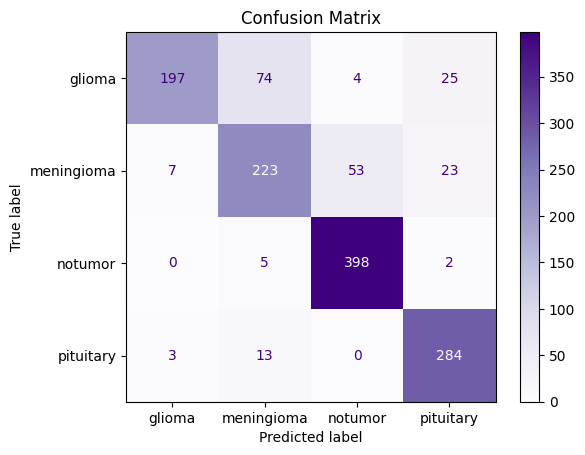

In [ ]:
cm = confusion_matrix(y_true, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8,6))
disp.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.show()

### Inference
- Both the baseline model and tuned model perform well with the test data, with **79% accuracy for baseline** model and **84% accuracy for tuned model**.
- The **5% increase in accuracy** indicates the tuned model generalizes the data better.
- Since we are talking about medical terms, **RECALL** would be **the most important metric** here, because we want to predict as many positive cases correctly as possible. For instance, we don't want to mispredict glioma as the other type of tumor, such as meningioma. On the confusion matrix, it is seen that many glioma cases were misclassified as meningioma, which is... definitely not good.
- Here's why. Based on my research, **glioma is the most malignant type of cancer**. With that being said, if a case of glioma is unpredicted, it could be bad: **delayed or even no treatment could put the patient's health at risk**! Though **glioma has a high precision**, as many cases are predicted as glioma. This is OK, but misclassifying other type of tumor (meningioma/no tumor/pituitary that is more benign) as the most malignant type of tumor? We **don't** want to have the **unnecessary anxiety** or **spend extra costs for treatment** we don't actually need.
- One of the factors why this can happen is because the **dataset is the lowest on glioma** (lowest on train and test), so maybe the **model didn't train enough on glioma** and need more reference here. To address this, we can **re-adjust the weight**, heavily emphasizing on glioma, because we want to catch glioma cases aggresively, but not cause too many false positives.
- Next, **meningioma has moderate precision and recall**. Some glioma cases are misclassified as meningioma and some meningioma cases are misclassified as no tumor. Again, the more malignant type of tumor is misclassified to the more benign type -- which can lead to delayed treatment. Though meningioma is a common type of brain tumor and it is not as deadly as glioma, it is not ideal to misclassify a disease.
- **No tumor has high recall and high precision**. This is good because the model captures many no tumor case correctly, eliminating the unnecessary anxiety. This may happen because the dataset has more no tumor images, so the model may capture the pattern. However, some cases of meningioma is classified as no tumor, which may delay the treatment. Having high recall and precision here is good but not as critical as catching the disease, especially the more malignant ones.
- **Pituitary also has high recall and high precision**. Again, this is good, but not as critical as having a high recall on glioma. 🧠

---

### Key Takeaways
- Relating to medical context, **accuracy cannot be a standalone metric -- RECALL would be the most important metric** to look at. Despite having a high accuracy for both models, the recall, especially for the malingnant type of tumor, is bad. This can be improved by **expanding the dataset, adjusting the weight especially on glioma, and doing more data augmentation** (checking the image of how glioma scans are. For example if there are too many noise/too dark in the glioma images, we can adjust the brightness more).
- When having low recall and precision, it is helpful to **look at the confusion matrix**, because we can see the classes that was predicted incorrectly.
- **Understanding the context and nature of the data**, such as understanding what the diseases actually are, **help us to drive more useful conclusions**. This is a medical data and this is my first time working on a brain disease dataset, so my knowledge is still limited. However, doing a small research on the context helps to understand what is the focus or objective of this model (esp. to catch more malignant tumor types).
- Further testing with other architectures would be insightful. I have tried to use ResNet, but the limited resources to GPU makes it hard to run quickly and I ran out of resources 😅

## e. Video Explanation
Accessible [here](https://drive.google.com/file/d/1viyEEqzj7CHhtw7dsZWcozgsedI8tKbd/view?usp=drive_link)